In [18]:
import pandas as pd

train_data = pd.read_csv("train.csv")
print(train_data.head())
print(train_data.info())
print(train_data.isnull().sum())

                                                text      category
0                     I am still waiting on my card?  card_arrival
1  What can I do if my card still hasn't arrived ...  card_arrival
2  I have been waiting over a week. Is the card s...  card_arrival
3  Can I track my card while it is in the process...  card_arrival
4  How do I know if I will get my card, or if it ...  card_arrival
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None
text        0
category    0
dtype: int64


In [19]:
from transformers import DistilBertTokenizer

# Initializing the DistilBERT Splitter
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Example: Segmentation and encoding of the first text
example_text = train_data['text'][0]
encoded_input = tokenizer(
    example_text,
    padding="max_length",   # Alignment length
    truncation=True,        # Truncate long text
    max_length=64,          # Setting the maximum length
    return_tensors="pt"     # Returns the tensor in PyTorch format
)

# View the encoded results
print("Tokens:", tokenizer.tokenize(example_text))
print("Input IDs:", encoded_input['input_ids'])
print("Attention Mask:", encoded_input['attention_mask'])


Tokens: ['i', 'am', 'still', 'waiting', 'on', 'my', 'card', '?']
Input IDs: tensor([[ 101, 1045, 2572, 2145, 3403, 2006, 2026, 4003, 1029,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [20]:
# Segmentation and coding of the entire dataset
def encode_data(data, tokenizer, max_length=64):
    encoded = tokenizer(
        list(data['text']),       # text list
        padding="max_length",     # Fill to maximum length
        truncation=True,          # Truncate long text
        max_length=max_length,    # Setting the maximum length
        return_tensors="pt"       # Return PyTorch tensor
    )
    return encoded

# Encoding of training and test data
train_encoded = encode_data(train_data, tokenizer)
test_data = pd.read_csv("test.csv")
test_encoded = encode_data(test_data, tokenizer)

# Example of printing training data after encoding
print("Train Input IDs shape:", train_encoded['input_ids'].shape)
print("Train Attention Mask shape:", train_encoded['attention_mask'].shape)


Train Input IDs shape: torch.Size([10003, 64])
Train Attention Mask shape: torch.Size([10003, 64])


In [21]:
from sklearn.preprocessing import LabelEncoder

# tag encoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['category'])
test_labels = label_encoder.transform(test_data['category'])

# Printing categories and corresponding codes
print("category mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


category mapping: {'Refund_not_showing_up': 0, 'activate_my_card': 1, 'age_limit': 2, 'apple_pay_or_google_pay': 3, 'atm_support': 4, 'automatic_top_up': 5, 'balance_not_updated_after_bank_transfer': 6, 'balance_not_updated_after_cheque_or_cash_deposit': 7, 'beneficiary_not_allowed': 8, 'cancel_transfer': 9, 'card_about_to_expire': 10, 'card_acceptance': 11, 'card_arrival': 12, 'card_delivery_estimate': 13, 'card_linking': 14, 'card_not_working': 15, 'card_payment_fee_charged': 16, 'card_payment_not_recognised': 17, 'card_payment_wrong_exchange_rate': 18, 'card_swallowed': 19, 'cash_withdrawal_charge': 20, 'cash_withdrawal_not_recognised': 21, 'change_pin': 22, 'compromised_card': 23, 'contactless_not_working': 24, 'country_support': 25, 'declined_card_payment': 26, 'declined_cash_withdrawal': 27, 'declined_transfer': 28, 'direct_debit_payment_not_recognised': 29, 'disposable_card_limits': 30, 'edit_personal_details': 31, 'exchange_charge': 32, 'exchange_rate': 33, 'exchange_via_app': 

In [22]:
import numpy as np
from collections import Counter

# Statistics on the frequency of each category
category_counts = Counter(train_data['category'])

# Total sample size
total_samples = len(train_data)

# Calculation of weights (formula: total number of samples / (number of categories * number of samples per category))
class_weights = {category: total_samples / (len(category_counts) * count) 
                 for category, count in category_counts.items()}

# Dictionary converted to category numbers
class_weights_numeric = {label_encoder.transform([category])[0]: weight 
                         for category, weight in class_weights.items()}

# Print category weights
print("Category Weights (Category: Weights):", class_weights)
print("The weight corresponding to the category number:", class_weights_numeric)


Category Weights (Category: Weights): {'card_arrival': 0.8490790255496138, 'card_linking': 0.934597776324395, 'exchange_rate': 1.1599025974025974, 'card_payment_wrong_exchange_rate': 0.7778987479586282, 'extra_charge_on_statement': 0.7825848849945235, 'pending_cash_withdrawal': 0.9084551811824539, 'fiat_currency_support': 1.031024531024531, 'card_delivery_estimate': 1.1599025974025974, 'automatic_top_up': 1.022906227630637, 'card_not_working': 1.1599025974025974, 'exchange_via_app': 1.100924499229584, 'lost_or_stolen_card': 1.5842572062084257, 'age_limit': 1.1809917355371902, 'pin_blocked': 1.1296442687747035, 'contactless_not_working': 3.7116883116883117, 'top_up_by_bank_transfer_charge': 1.1703521703521704, 'pending_top_up': 0.8718730933496034, 'cancel_transfer': 0.827446438911407, 'top_up_limits': 1.3392689784442362, 'wrong_amount_of_cash_received': 0.7217171717171718, 'card_payment_fee_charged': 0.6947010209042295, 'transfer_not_received_by_recipient': 0.7597022860180755, 'supporte

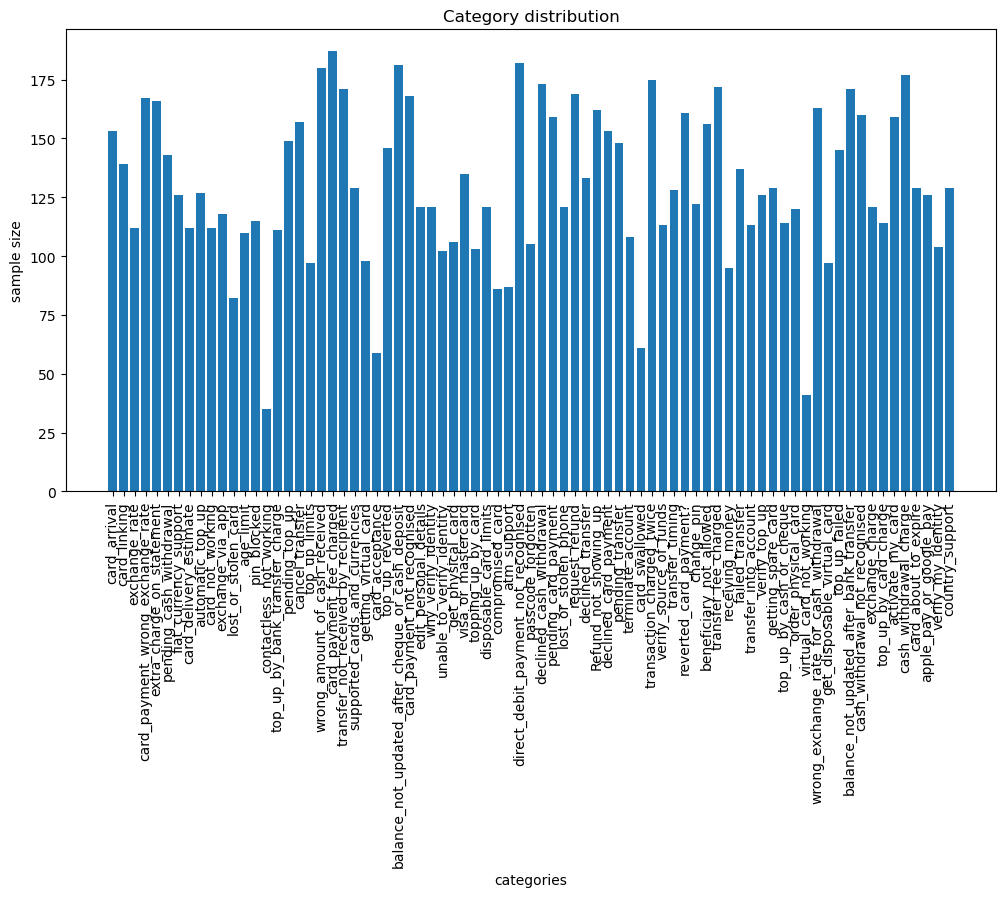

In [23]:
import matplotlib.pyplot as plt

# Histogram of category distribution
plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xticks(rotation=90)
plt.title("Category distribution")
plt.xlabel("categories")
plt.ylabel("sample size")
plt.show()


In [24]:
import torch
import torch.nn as nn

# Convert weights to tensor
weights_tensor = torch.tensor(
    [class_weights_numeric[i] for i in range(len(class_weights_numeric))], 
    dtype=torch.float
)

# Define the weighted cross-entropy loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Example: hypothetical model output and labeling
logits = torch.randn(4, len(class_weights_numeric))  # Output of the model
labels = torch.tensor([0, 1, 2, 3])                  # Category labels corresponding to the samples

# Calculation of weighted losses
loss = criterion(logits, labels)
print("Weighted cross-entropy loss:", loss.item())


Weighted cross-entropy loss: 4.690343379974365


In [25]:
from transformers import DistilBertForSequenceClassification

# Number of defined categories
num_labels = len(label_encoder.classes_)

# Loading pre-trained DistilBERT models
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW

# Setting hyperparameters
learning_rate = 5e-5
batch_size = 16
num_epochs = 5

# Use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Defining the Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)


c:\Users\34745\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Preparing the training set
train_dataset = TensorDataset(
    train_encoded['input_ids'], 
    train_encoded['attention_mask'], 
    torch.tensor(train_labels)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Preparing test sets (validation sets)
test_dataset = TensorDataset(
    test_encoded['input_ids'], 
    test_encoded['attention_mask'], 
    torch.tensor(test_labels)
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [28]:
import torch.nn as nn

# Convert weights to tensor
weights_tensor = torch.tensor(
    [class_weights_numeric[i] for i in range(len(class_weights_numeric))], 
    dtype=torch.float
).to(device)

# Define the weighted cross-entropy loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)


In [29]:
from tqdm import tqdm

# Recorded loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_train_loss = 0
    
    # training phase
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        # Load the data into the device and make sure the labels are of type LongTensor
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device).long()  # Make sure the type is LongTensor
        
        # Forward propagation (Hugging Face model automatically calculates loss)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Use Hugging Face's loss values directly
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    # validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            # Load the data into the device and make sure the labels are of type LongTensor
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()  # Make sure the type is LongTensor
            
            # forward propagation
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Use Hugging Face's loss values directly
            
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Average verification loss: {avg_val_loss:.4f}")


Epoch 1/5


  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [56:33<00:00,  5.42s/it]  


Average training loss: 1.8906
Average verification loss: 0.5609
Epoch 2/5


100%|██████████| 626/626 [56:57<00:00,  5.46s/it]  


Average training loss: 0.3683
Average verification loss: 0.3560
Epoch 3/5


100%|██████████| 626/626 [49:38<00:00,  4.76s/it]  


Average training loss: 0.1738
Average verification loss: 0.3097
Epoch 4/5


100%|██████████| 626/626 [48:03<00:00,  4.61s/it] 


Average training loss: 0.1017
Average verification loss: 0.3169
Epoch 5/5


100%|██████████| 626/626 [48:17<00:00,  4.63s/it]


Average training loss: 0.0703
Average verification loss: 0.3387


In [30]:
# Preservation of model weights
model.save_pretrained("distilbert_finetuned")
tokenizer.save_pretrained("distilbert_finetuned")


('distilbert_finetuned\\tokenizer_config.json',
 'distilbert_finetuned\\special_tokens_map.json',
 'distilbert_finetuned\\vocab.txt',
 'distilbert_finetuned\\added_tokens.json')

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Model predictor function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device).long()

            # forward propagation
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)  # Access to forecast categories

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Run the model and get predictions
test_preds, test_labels = evaluate_model(model, test_loader)


In [32]:
# Computational performance metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')  
recall = recall_score(test_labels, test_preds, average='weighted')        
f1 = f1_score(test_labels, test_preds, average='weighted')                

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9153
Precision: 0.9221
Recall: 0.9153
F1 Score: 0.9155


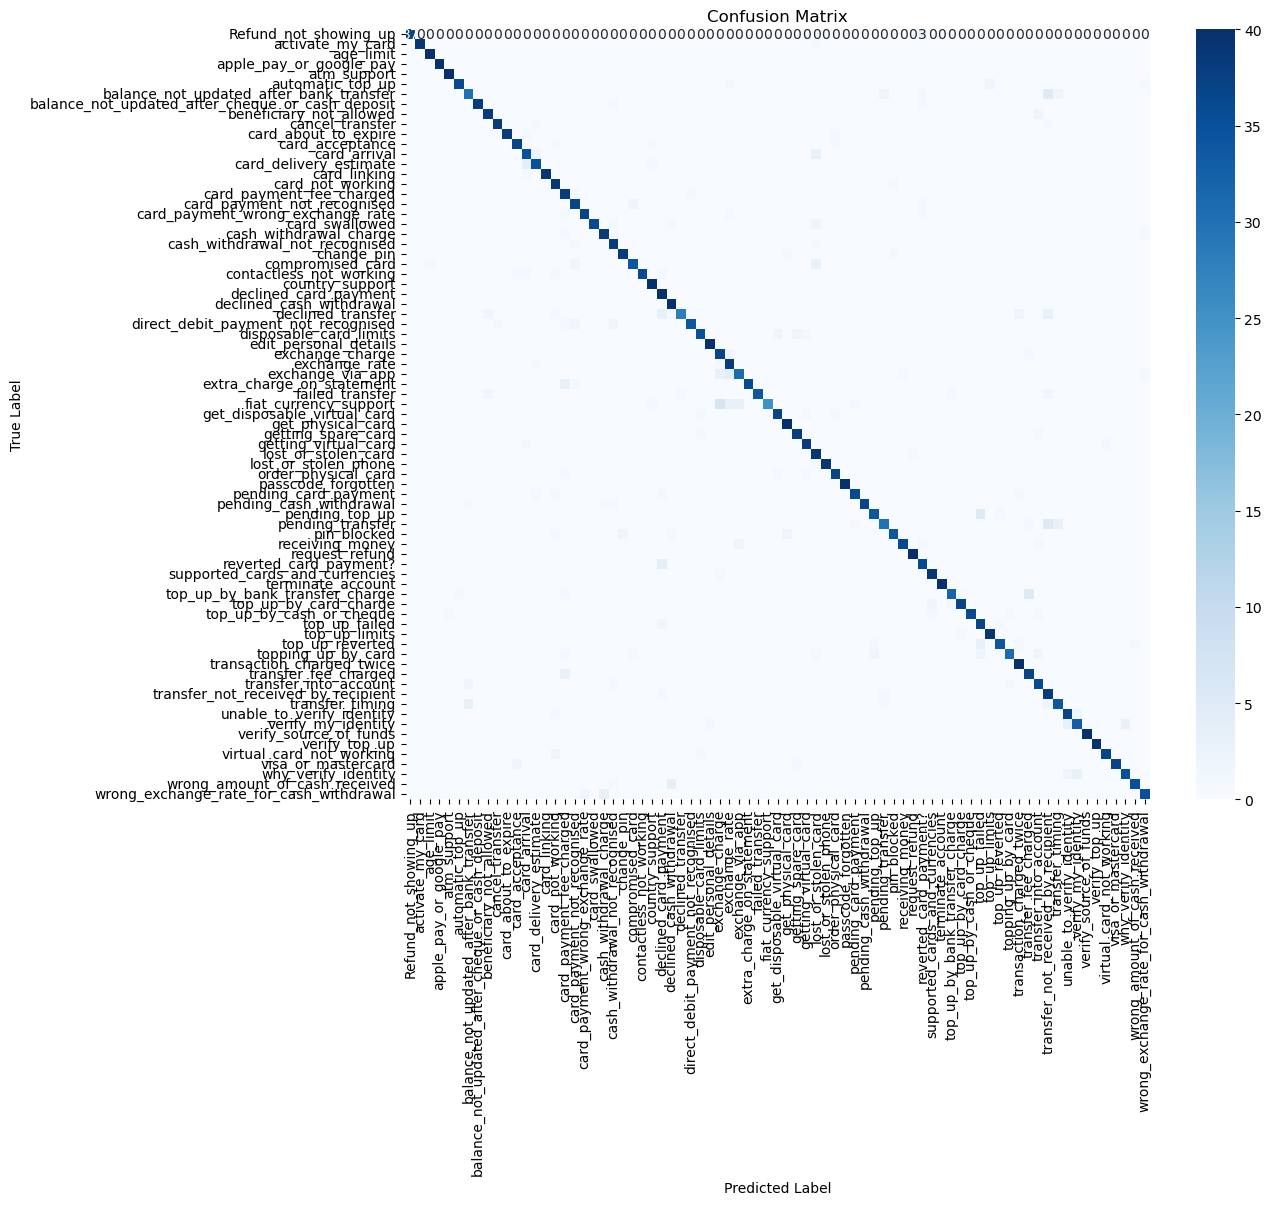

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
